# ネットワーク読み込み

In [46]:
import pypsa

# 最適化済みネットワークデータを読み込む
network = pypsa.Network('./complete_network/optimized_network_2024.nc')
print(f"ネットワークデータを読み込みました: {len(network.buses)} buses, {len(network.generators)} generators")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks


ネットワークデータを読み込みました: 49 buses, 210 generators


c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



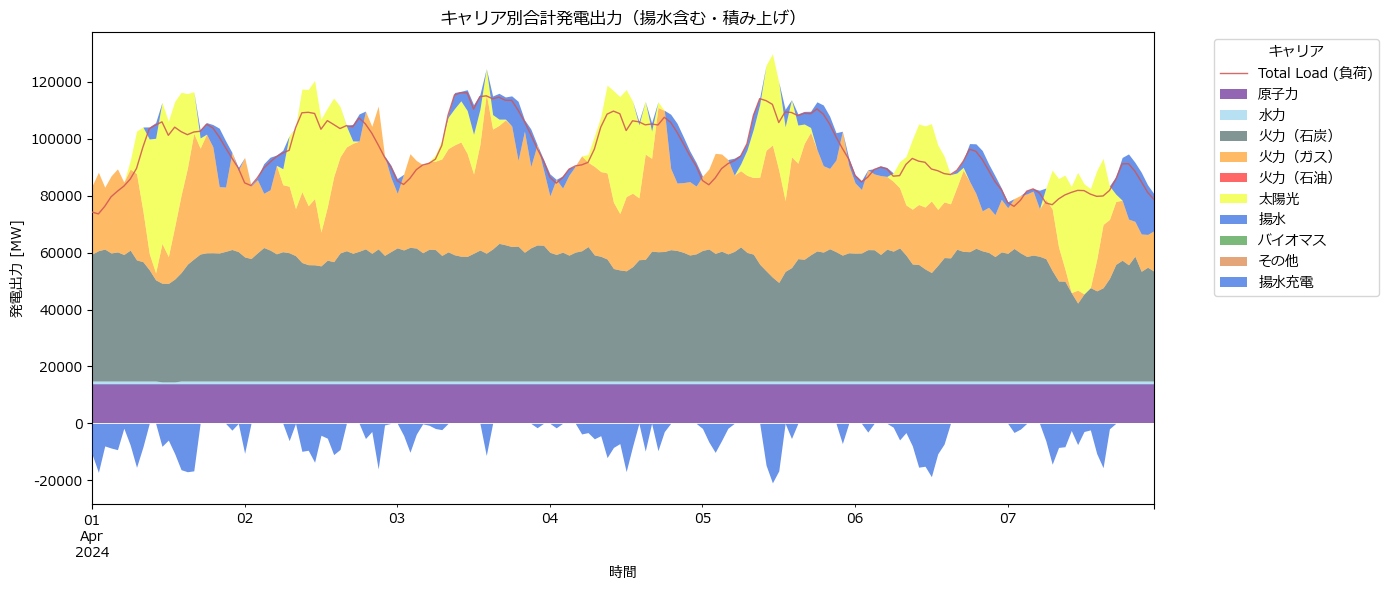

In [47]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_total_generation_by_carrier(network)

ネットワーク内のcarrier一覧:
['その他', 'バイオマス', '原子力', '太陽光', '水力', '火力（ガス）', '火力（石油）', '火力（石炭）']


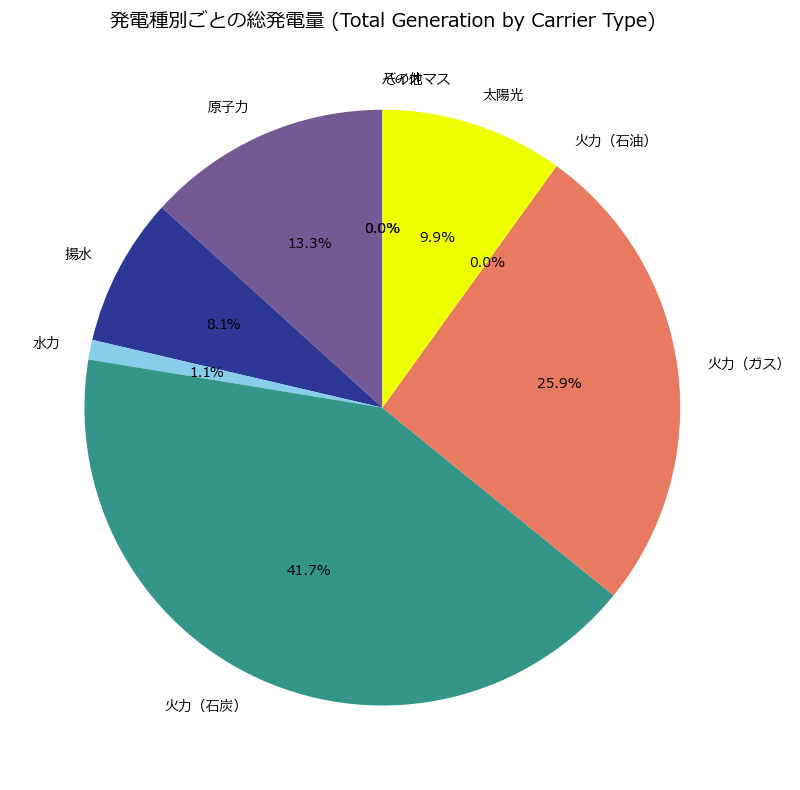

In [48]:
# 発電電力量を発電種別毎の円グラフで表示
import matplotlib.pyplot as plt

# 日本語フォント設定
plt.rcParams['font.family'] = 'Meiryo'  # Windows用
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け防止

desired_order = ["原子力", "揚水", "水力", "火力（石炭）", "火力（ガス）", "火力（石油）", "太陽光", "バイオマス", "その他"]
color_list = ["#745994", "#2C3796", "#87CEEB", "#339689", "#E77A61", "#FF0000", "#EEFF00", "#228B22", "#D2691E"]

# 発電種別ごとの総発電量を計算
generation_by_carrier = network.generators_t.p.sum().groupby(network.generators.carrier).sum()

# まずネットワークにどんなcarrierがあるか確認
print("ネットワーク内のcarrier一覧:")
print(generation_by_carrier.index.tolist())

# 揚水発電の発電量を追加
if hasattr(network, 'links'):
    phss_links = network.links[network.links['carrier'] == '揚水'].index
    if len(phss_links) > 0:
        phss_generation = network.links_t.p0[phss_links].clip(lower=0).sum().sum()
        generation_by_carrier['揚水'] = phss_generation

# desired_orderに従って並び替え（存在するもののみ）
ordered_generation = {}
for carrier in desired_order:
    if carrier in generation_by_carrier.index:
        ordered_generation[carrier] = generation_by_carrier[carrier]

# 色の対応を作成
colors_to_use = [color_list[desired_order.index(carrier)] for carrier in ordered_generation.keys()]

# 円グラフを作成
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(ordered_generation.values(), 
    labels=ordered_generation.keys(), 
    autopct='%1.1f%%',
    startangle=90, 
    colors=colors_to_use)
ax.set_title('発電種別ごとの総発電量 (Total Generation by Carrier Type)', fontsize=14)
plt.tight_layout()
plt.show()


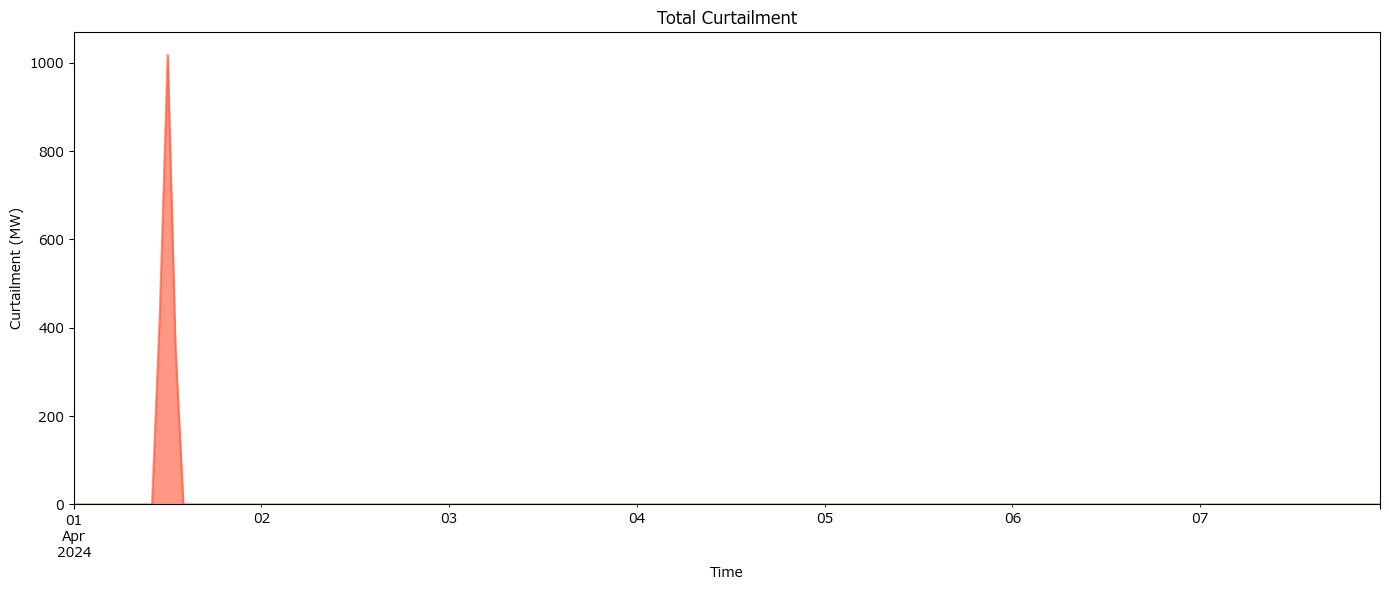

In [49]:
import matplotlib.pyplot as plt

# ネットワークの出力抑制（curtailment）を計算して表示
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p

# 時系列の出力抑制をプロット
curtailment_positive = curtailment.clip(lower=0)
fig, ax = plt.subplots(figsize=(14, 6))
curtailment_positive.sum(axis=1).plot.area(ax=ax, title='Total Curtailment',
                                       ylabel='Curtailment (MW)', xlabel='Time', 
                                       stacked=True, color='#FF6347AA')
plt.tight_layout()
plt.show()

# 送電線の潮流を表示

プロット対象の連系線: 10本
['北海道本州連系設備', '東北東京間連系線', '東京中部間連系線', '中部北陸連系設備', '中部関西連系線', '北陸関西連系線', '関西中国間連系線', '関西四国間連系設備', '中国四国間連系線', '中国九州間連系線']


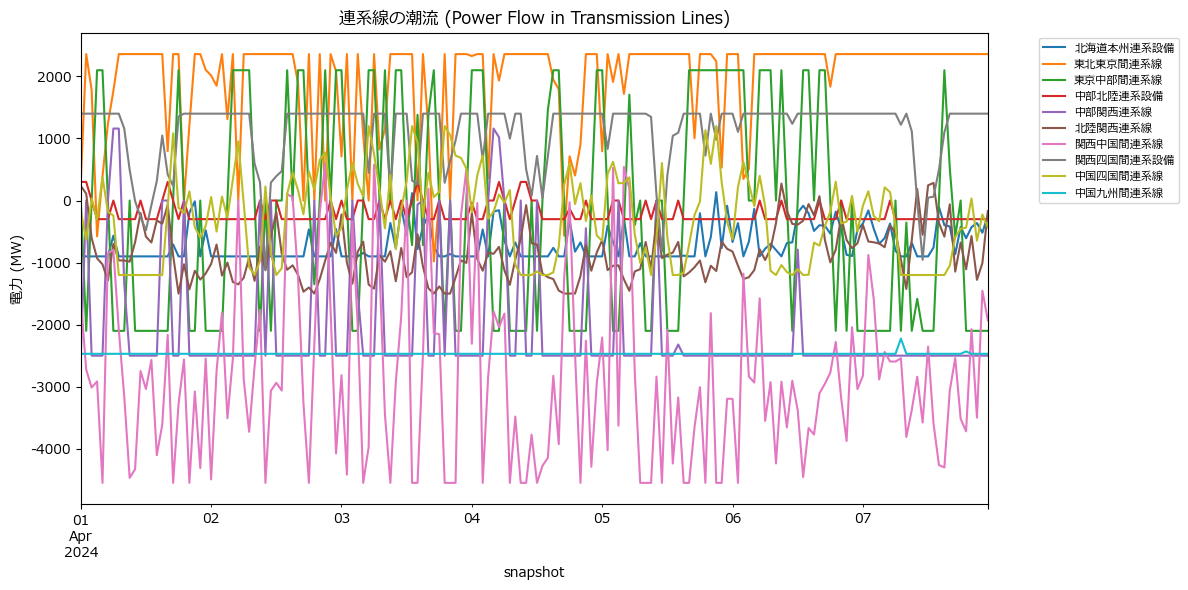

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止

# 連系線のみをフィルタリング（carrier='DC'または名前に'連系'を含むリンク）
transmission_links = network.links[
    (network.links['carrier'] == 'DC') | 
    (network.links.index.str.contains('連系', na=False))
].index

if len(transmission_links) > 0:
    network.links_t.p0[transmission_links].plot(
        title="連系線の潮流 (Power Flow in Transmission Lines)", 
        figsize=(12, 6),
        ylabel="電力 (MW)"
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    print(f"プロット対象の連系線: {len(transmission_links)}本")
    print(transmission_links.tolist())
else:
    print("連系線が見つかりませんでした")

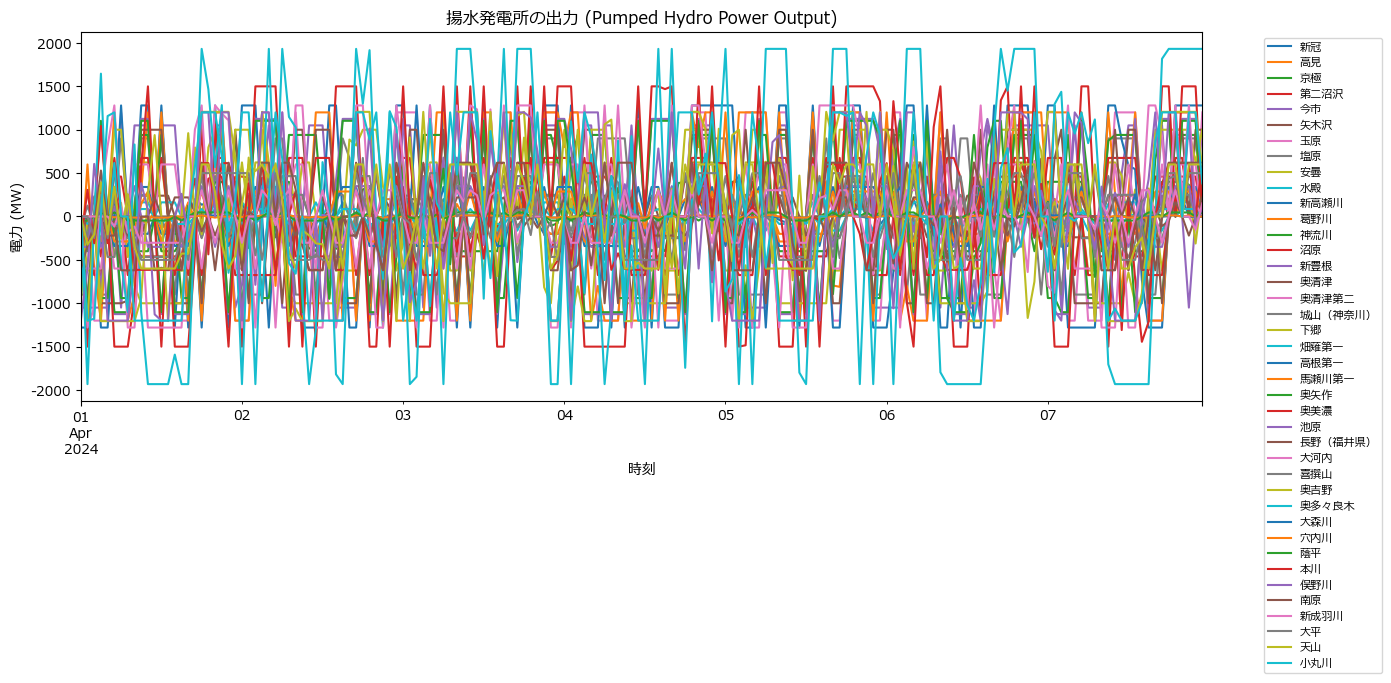

揚水発電所の数: 40

各揚水発電所の出力統計 (MW):
name     新冠            高見            京極          第二沼沢      今市    矢木沢      玉原  \
min  -200.0 -2.000000e+02 -4.000000e+02 -4.600000e+02 -1050.0 -240.0 -1200.0   
max   200.0  2.000000e+02  4.000000e+02  4.600000e+02  1050.0  240.0  1200.0   
mean    0.0  2.030122e-15  4.060244e-15  2.368476e-15     0.0    0.0     0.0   

name     塩原            安曇            水殿  ...           大森川   穴内川  \
min  -900.0 -6.230000e+02 -1.630000e+02  ... -1.220000e+01 -12.5   
max   900.0  6.230000e+02  1.630000e+02  ...  1.220000e+01  12.5   
mean    0.0 -2.706829e-15 -6.767074e-16  ... -3.595008e-16   0.0   

name            蔭平            本川           俣野川            南原          新成羽川  \
min  -4.650000e+01 -6.150000e+02 -1.200000e+03 -6.200000e+02 -3.030000e+02   
max   4.650000e+01  6.150000e+02  1.200000e+03  6.200000e+02  3.030000e+02   
mean  1.691768e-16 -4.060244e-15  1.759439e-14  5.413659e-15  5.413659e-15   

name            大平            天山           小丸川  
min  -5.00000

In [51]:
# 揚水発電所のリンク（発電・揚水）の出力をプロット
if len(pumped_hydro_links) > 0:
    # 揚水発電所の出力時系列データを取得
    pumped_hydro_power = network.links_t.p0[pumped_hydro_links]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    pumped_hydro_power.plot(ax=ax, title='揚水発電所の出力 (Pumped Hydro Power Output)', 
                            ylabel='電力 (MW)', xlabel='時刻', legend=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()
    
    print(f"揚水発電所の数: {len(pumped_hydro_links)}")
    print("\n各揚水発電所の出力統計 (MW):")
    print(pumped_hydro_power.describe().loc[['min', 'max', 'mean']])
    
    # 正の値（発電）と負の値（揚水）を分けて集計
    generation = pumped_hydro_power.clip(lower=0).sum().sum()
    pumping = pumped_hydro_power.clip(upper=0).sum().sum()
    print(f"\n総発電量: {generation:.2f} MWh")
    print(f"総揚水量: {pumping:.2f} MWh")
else:
    print("揚水発電所のリンクが見つかりませんでした")

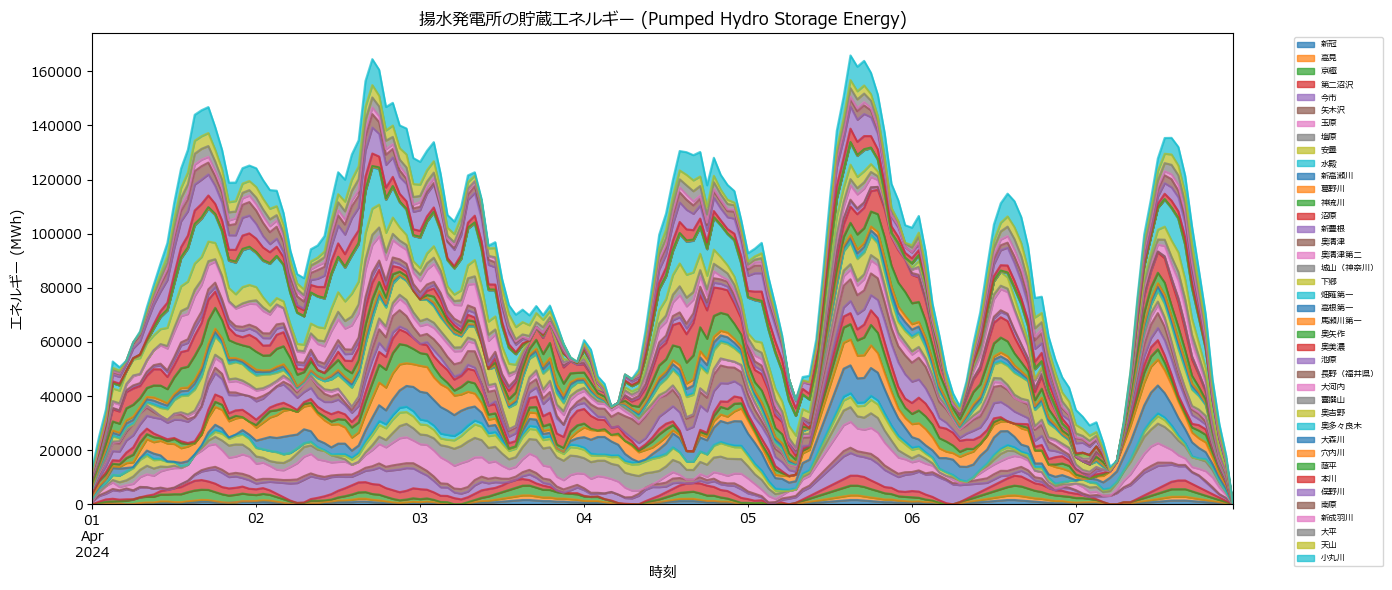

揚水発電所の数: 40

各揚水発電所の最大・最小・平均貯蔵エネルギー (MWh):
name           新冠           高見           京極         第二沼沢      今市          矢木沢  \
min     -0.000000    -0.000000    -0.000000    -0.000000    -0.0    -0.000000   
max   1600.000000  1712.000000  3756.800000  3680.000000  8400.0  1920.000000   
mean   593.900043   612.081434  1642.888676  1784.615349  3562.5   953.571429   

name           玉原           塩原           安曇           水殿  ...        大森川  \
min     -0.000000    -0.000000    -0.000000    -0.000000  ...  -0.000000   
max   9600.000000  7200.000000  4984.000000  1960.000000  ...  96.000000   
mean  4453.216327  3249.107143  2410.416667   657.322917  ...  34.464956   

name         穴内川          蔭平           本川          俣野川           南原  \
min    -0.000000   -0.000000    -0.000000    -0.000000    -0.000000   
max   104.000000  376.000000  4920.000000  9600.000000  4960.000000   
mean   45.212798  141.131234  2043.925668  4107.018339  1899.614896   

name         新成羽川           大平           天

In [32]:
# 揚水発電所のリンクを特定
pumped_hydro_links = network.links[network.links['carrier'] == '揚水'].index

# 揚水発電所の貯蔵エネルギー（蓄電状態）を積み上げグラフでプロット
if len(network.stores) > 0:
    # 揚水発電所（Store）の蓄電量時系列データを取得
    storage_energy = network.stores_t.e
    
    if not storage_energy.empty:
        fig, ax = plt.subplots(figsize=(14, 6))
        storage_energy.plot(
            ax=ax, 
            kind='area',
            stacked=True,
            alpha=0.7,
            title='揚水発電所の貯蔵エネルギー (Pumped Hydro Storage Energy)', 
            ylabel='エネルギー (MWh)', 
            xlabel='時刻'
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        plt.tight_layout()
        plt.show()
        
        print(f"揚水発電所の数: {len(network.stores)}")
        print("\n各揚水発電所の最大・最小・平均貯蔵エネルギー (MWh):")
        print(storage_energy.describe().loc[['min', 'max', 'mean']])
    else:
        print("揚水発電所の貯蔵エネルギーデータがありません")
else:
    print("ネットワークに揚水発電所（Store）が含まれていません")

In [33]:
# 揚水リンクの効率を確認
print(network.links.loc[pumped_hydro_links, ['bus0', 'bus1', 'efficiency', 'p_nom']])

            bus0 bus1  efficiency   p_nom
name                                     
新冠            新冠  北海道         0.7   200.0
高見            高見  北海道         0.7   200.0
京極            京極  北海道         0.7   400.0
第二沼沢        第二沼沢   東北         0.7   460.0
今市            今市   東京         0.7  1050.0
矢木沢          矢木沢   東京         0.7   240.0
玉原            玉原   東京         0.7  1200.0
塩原            塩原   東京         0.7   900.0
安曇            安曇   東京         0.7   623.0
水殿            水殿   東京         0.7   163.0
新高瀬川        新高瀬川   東京         0.7  1280.0
葛野川          葛野川   東京         0.7  1200.0
神流川          神流川   東京         0.7   940.0
沼原            沼原   東京         0.7   675.0
新豊根          新豊根   中部         0.7  1125.0
奥清津          奥清津   東京         0.7  1000.0
奥清津第二      奥清津第二   東京         0.7   600.0
城山（神奈川）  城山（神奈川）   東京         0.7   250.0
下郷            下郷   東北         0.7  1000.0
畑薙第一        畑薙第一   中部         0.7    86.0
高根第一        高根第一   中部         0.7   340.0
馬瀬川第一      馬瀬川第一   中部         0.7 

In [35]:
# 揚水リンクの効率を確認
print(network.links.loc[pumped_hydro_links, ['bus0', 'bus1', 'efficiency', 'p_nom']])

            bus0 bus1  efficiency   p_nom
name                                     
新冠            新冠  北海道         0.7   200.0
高見            高見  北海道         0.7   200.0
京極            京極  北海道         0.7   400.0
第二沼沢        第二沼沢   東北         0.7   460.0
今市            今市   東京         0.7  1050.0
矢木沢          矢木沢   東京         0.7   240.0
玉原            玉原   東京         0.7  1200.0
塩原            塩原   東京         0.7   900.0
安曇            安曇   東京         0.7   623.0
水殿            水殿   東京         0.7   163.0
新高瀬川        新高瀬川   東京         0.7  1280.0
葛野川          葛野川   東京         0.7  1200.0
神流川          神流川   東京         0.7   940.0
沼原            沼原   東京         0.7   675.0
新豊根          新豊根   中部         0.7  1125.0
奥清津          奥清津   東京         0.7  1000.0
奥清津第二      奥清津第二   東京         0.7   600.0
城山（神奈川）  城山（神奈川）   東京         0.7   250.0
下郷            下郷   東北         0.7  1000.0
畑薙第一        畑薙第一   中部         0.7    86.0
高根第一        高根第一   中部         0.7   340.0
馬瀬川第一      馬瀬川第一   中部         0.7 

In [ ]:
# 往復効率75%にしたい場合
# √0.75 ≈ 0.866 を充電・放電の両方に適用
roundtrip_efficiency = 0.75
single_efficiency = roundtrip_efficiency ** 0.5  # 約0.866

network.links.loc[pumped_hydro_links, 'efficiency'] = single_efficiency

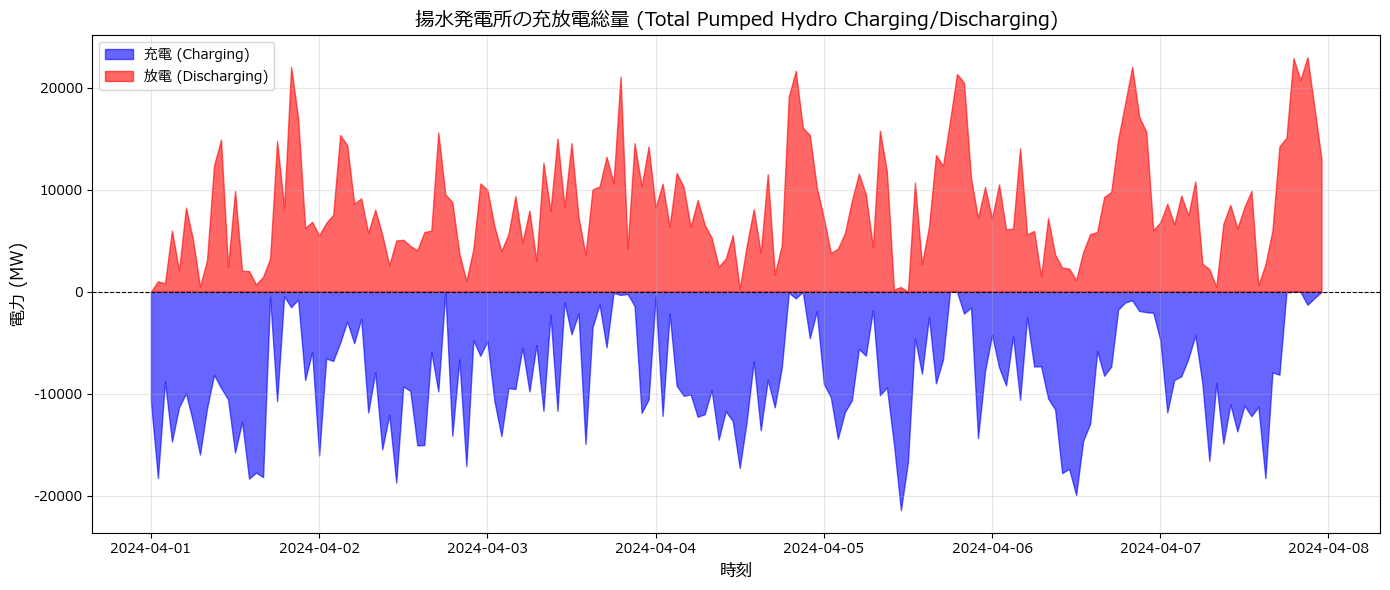


総充電量: 1406681.67 MWh
総放電量: 1406681.67 MWh
エネルギー効率: 100.00%


In [ ]:
# 揚水発電所の充電（負値）と放電（正値）を分けて集計してプロット
if len(pumped_hydro_links) > 0:
    # 充電量（負の値）と放電量（正の値）を分離
    charging = pumped_hydro_power.clip(upper=0).sum(axis=1)  # 負の値（充電）
    discharging = pumped_hydro_power.clip(lower=0).sum(axis=1)  # 正の値（放電）
    
    # プロット
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.fill_between(charging.index, charging, 0, alpha=0.6, color='blue', label='充電 (Charging)')
    ax.fill_between(discharging.index, 0, discharging, alpha=0.6, color='red', label='放電 (Discharging)')
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('揚水発電所の充放電総量 (Total Pumped Hydro Charging/Discharging)', fontsize=14)
    ax.set_ylabel('電力 (MW)', fontsize=12)
    ax.set_xlabel('時刻', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 統計情報を表示（ストアベースで正しい効率を計算）
    total_charging_bus0 = abs(charging.sum())  # bus0側の充電消費電力
    total_discharging_bus0 = discharging.sum()  # bus0側の放電供給電力
    
    # ストアのエネルギー変化から実際の効率を計算
    if len(network.stores) > 0:
        # ストアの全エネルギー変化を時系列で取得
        store_energy_diff = network.stores_t.e.diff().fillna(0)
        
        # 充電期間と放電期間を特定（全リンクの合計で判定）
        total_link_power = pumped_hydro_power.sum(axis=1)
        charging_periods = total_link_power < -0.1
        discharging_periods = total_link_power > 0.1
        
        # ストアの充電量・放電量を計算
        store_charged = store_energy_diff[charging_periods].sum().sum()  # ストアへの蓄積
        store_discharged = abs(store_energy_diff[discharging_periods].sum().sum())  # ストアからの放出
        
        # 往復効率の計算
        avg_efficiency = network.links.loc[pumped_hydro_links, 'efficiency'].mean()
        expected_roundtrip = avg_efficiency ** 2
        
        print(f"\n【充電プロセス】")
        print(f"  bus0消費電力: {total_charging_bus0:.2f} MWh")
        print(f"  ストア蓄積: {store_charged:.2f} MWh")
        print(f"  充電効率: {(store_charged/total_charging_bus0):.3f} ({store_charged/total_charging_bus0*100:.1f}%)")
        
        print(f"\n【放電プロセス】")
        print(f"  ストア放出: {store_discharged:.2f} MWh")
        print(f"  bus0供給電力: {total_discharging_bus0:.2f} MWh")
        print(f"  放電効率: {(total_discharging_bus0/store_discharged):.3f} ({total_discharging_bus0/store_discharged*100:.1f}%)")
        
        print(f"\n【往復効率】")
        print(f"  効率設定値: {avg_efficiency:.3f}")
        print(f"  期待往復効率: {expected_roundtrip:.3f} ({expected_roundtrip*100:.1f}%)")
        print(f"  実測往復効率: {(total_discharging_bus0/total_charging_bus0):.3f} ({total_discharging_bus0/total_charging_bus0*100:.1f}%)")
        print(f"  → bus0基準では効率損失が見えないため100%に近い値になります")
        print(f"  → 実際の損失はストア側で発生しています")
    else:
        print(f"\n総充電量 (bus0): {total_charging_bus0:.2f} MWh")
        print(f"総放電量 (bus0): {total_discharging_bus0:.2f} MWh")
        print(f"bus0効率: {(total_discharging_bus0 / total_charging_bus0 * 100):.2f}%")
else:
    print("揚水発電所のリンクが見つかりませんでした")

# 地図上にプロットする。

In [35]:
import folium
import pandas as pd

# Helper: try various column names and return DataFrame with lat/lon
def _get_bus_locations_df(network):
    df = network.buses.copy()
    # common PyPSA default: x (lon), y (lat)
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    # already lat/lon
    elif {'lat','lon'}.issubset(df.columns):
        pass
    # alternative naming
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    # some workflows store coords in a list/tuple column called 'coords'
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    # ensure numeric and drop invalid rows
    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# get bus locations (raises helpful error if not found)
bus_locations = _get_bus_locations_df(network)

# 地図の中心をバスの平均位置に設定
center_lat = bus_locations['lat'].mean()
center_lon = bus_locations['lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# バスごとにマーカーを追加
for bus_name, row in bus_locations.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=str(bus_name),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# 保存と表示
m.save('bus_locations_map.html')

m

In [18]:
# プロット: バスとリンク（network.links / network.lines）を地図上に描画して保存
# 既に folium, network, Year_of_analysis が定義されている前提
import folium, pandas as pd

# 再利用可能なバス位置取得関数 (cell '#VSC-50c70af2' と同じロジック)
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

# バス位置取得
bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        # bus 名が bus_locations にあるか確認
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

# network.links があれば描画
links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

# network.lines があれば描画（存在するネットワークでは lines が無い場合もある）
if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

# 出力・保存
out_file = f'bus_links_map.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

# Jupyter で表示するためにマップオブジェクトを返す
m_links


バス: 49 個、リンク描画: 50 本。地図を保存しました -> bus_links_map.html


In [20]:
# Duplicate plotting cell made robust as well
import folium

# re-use the helper from earlier; define again to be safe in isolation
def _get_bus_locations_df(network):
    df = network.buses.copy()
    if {'y','x'}.issubset(df.columns):
        df = df.rename(columns={'y':'lat','x':'lon'})
    elif {'lat','lon'}.issubset(df.columns):
        pass
    elif {'latitude','longitude'}.issubset(df.columns):
        df = df.rename(columns={'latitude':'lat','longitude':'lon'})
    elif 'coords' in df.columns:
        coords = df['coords'].apply(lambda v: (v[0], v[1]) if isinstance(v, (list,tuple)) and len(v)>=2 else (None,None))
        df[['lat','lon']] = pd.DataFrame(coords.tolist(), index=df.index)
    else:
        raise ValueError("network.busesに位置情報のカラムが見つかりません。期待される: x/y, lon/lat, latitude/longitude, or coords")

    df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
    df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
    df = df.dropna(subset=['lat','lon'])
    if df.empty:
        raise ValueError("有効なバス座標が見つかりません。")
    return df[['lat','lon']]

bus_locations = _get_bus_locations_df(network)

m_links = folium.Map(location=[bus_locations['lat'].mean(), bus_locations['lon'].mean()], zoom_start=5)

# バスをマーカーで追加
for bus_name, r in bus_locations.iterrows():
    folium.CircleMarker(
        location=[r['lat'], r['lon']],
        radius=6,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        popup=str(bus_name)
    ).add_to(m_links)

# 汎用的にリンクのバス列を検出して描画する関数
def _plot_links_from_df(df, color='#d63333', weight=3, prefix=''):
    bus_cols = [c for c in df.columns if c.startswith('bus')]
    if len(bus_cols) < 2:
        return 0
    count = 0
    for name, row in df.iterrows():
        b0 = row[bus_cols[0]]
        b1 = row[bus_cols[1]]
        if (b0 in bus_locations.index) and (b1 in bus_locations.index):
            coords = [
                [bus_locations.loc[b0, 'lat'], bus_locations.loc[b0, 'lon']],
                [bus_locations.loc[b1, 'lat'], bus_locations.loc[b1, 'lon']]
            ]
            popup = f"{prefix}{name}: {b0} ↔ {b1}"
            folium.PolyLine(coords, color=color, weight=weight, opacity=0.7, popup=popup).add_to(m_links)
            count += 1
    return count

links_plotted = 0
if hasattr(network, "links") and len(network.links) > 0:
    links_plotted += _plot_links_from_df(network.links, color='#ff4500', weight=3, prefix='link ')

if hasattr(network, "lines") and len(network.lines) > 0:
    links_plotted += _plot_links_from_df(network.lines, color='#0066cc', weight=2, prefix='line ')

out_file = f'bus_links_map.html'
m_links.save(out_file)
print(f"バス: {len(bus_locations)} 個、リンク描画: {links_plotted} 本。地図を保存しました -> {out_file}")

m_links


バス: 49 個、リンク描画: 50 本。地図を保存しました -> bus_links_map.html
